In [1]:
import pandas as pd

df = pd.read_csv("../data/Prompt1AccountLevel.csv")
seat_df = pd.read_csv("../data/Prompt1SeatLevel.csv")
game_df = pd.read_csv("../data/Prompt1GameLevel.csv") 

# **Data Cleaning**

Remove all season ticket holders as we do not want to advertize to them

In [2]:
# Remove rows where STM value is 1 and drop the STM column
if 'STM' in df.columns:
    df = df[df['STM'] != 1].drop(columns=['STM'])

df.head()

,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement
0,2023,1,0,0,0,$467.00,0,F,12.0,872.0,Low
1,2023,2,2,0,0,$116.00,1,A,47.0,485.0,Low
2,2023,3,3,0,0,$107.00,1,B,6.0,896.0,Low
3,2023,4,0,0,3,$27.00,1,C,3.0,467.0,High
4,2023,5,0,0,2,$14.00,1,A,4.0,582.0,Medium


Count the number of tickets bought by each user

In [3]:
# Compute the number of unique games attended per account per season
unique_games_count = seat_df.groupby(["Season", "AccountNumber"])["Game"].nunique().reset_index()
unique_games_count.rename(columns={"Game": "UniqueGamesAttended"}, inplace=True)

# Compute the total number of tickets purchased per account per season
total_tickets_count = seat_df.groupby(["Season", "AccountNumber"]).size().reset_index(name="TotalTicketsPurchased")

# Merge the computed values into account_level table
df = df.merge(unique_games_count, on=["Season", "AccountNumber"], how="left")
df = df.merge(total_tickets_count, on=["Season", "AccountNumber"], how="left")

# Fill NaN values with 0 (in case an account didn't attend any games)
# df.fillna(0, inplace=True)

# Display the updated dataset
df.head()

,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement,UniqueGamesAttended,TotalTicketsPurchased
0,2023,1,0,0,0,$467.00,0,F,12.0,872.0,Low,1,24
1,2023,2,2,0,0,$116.00,1,A,47.0,485.0,Low,1,2
2,2023,3,3,0,0,$107.00,1,B,6.0,896.0,Low,1,3
3,2023,4,0,0,3,$27.00,1,C,3.0,467.0,High,1,3
4,2023,5,0,0,2,$14.00,1,A,4.0,582.0,Medium,1,2


In [4]:
# Map SocialMediaEngagement categories to numerical values
social_media_mapping = {
    "Low": 0.3,
    "Medium": 0.6,
    "High": 1.0
}

df["SocialMediaEngagement"] = df["SocialMediaEngagement"].map(social_media_mapping)

Calculate tier frequencies

In [5]:
# Count the number of games per tier for each AccountNumber and Season
tier_counts = seat_df.groupby(["Season", "AccountNumber", "GameTier"]).size().unstack(fill_value=0)

# Rename columns to indicate they represent tier counts
tier_counts.columns = [f"Tier{col}" for col in tier_counts.columns]
                                                                                      
# Reset index to keep AccountNumber and Season as columns
tier_counts.reset_index(inplace=True)

df = df.merge(tier_counts, on=["Season", "AccountNumber"], how="left")

# Compute fractions for each tier
df["TierAFraction"] = df["TierA"] / df["TotalTicketsPurchased"]
df["TierBFraction"] = df["TierB"] / df["TotalTicketsPurchased"]
df["TierCFraction"] = df["TierC"] / df["TotalTicketsPurchased"]
df["TierDFraction"] = df["TierD"] / df["TotalTicketsPurchased"]

# Compute combined fractions for Tier C + D and Tier A + B
df["TierABFraction"] = (df["TierA"] + df["TierB"]) / df["TotalTicketsPurchased"]
df["TierCDFraction"] = (df["TierC"] + df["TierD"]) / df["TotalTicketsPurchased"]

# Determine the highest attended tier per account
df["FavoriteTier"] = df[["TierA", "TierB", "TierC", "TierD"]].idxmax(axis=1)
df["FavoriteTier"] = df["FavoriteTier"].str.replace("Tier", "")

df.head()


,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,...,TierB,TierC,TierD,TierAFraction,TierBFraction,TierCFraction,TierDFraction,TierABFraction,TierCDFraction,FavoriteTier
0,2023,1,0,0,0,$467.00,0,F,12.0,872.0,...,0,0,24,0.0,0.0,0.0,1.0,0.0,1.0,D
1,2023,2,2,0,0,$116.00,1,A,47.0,485.0,...,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,A
2,2023,3,3,0,0,$107.00,1,B,6.0,896.0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,1.0,D
3,2023,4,0,0,3,$27.00,1,C,3.0,467.0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,1.0,D
4,2023,5,0,0,2,$14.00,1,A,4.0,582.0,...,0,0,2,0.0,0.0,0.0,1.0,0.0,1.0,D


Classify games as weekend or weekday

In [6]:
seat_df["GameDate"] = pd.to_datetime(seat_df["GameDate"])

# Identify whether each game was on a weekend (Saturday or Sunday)
seat_df["IsWeekend"] = seat_df["GameDate"].dt.dayofweek.isin([5, 6]).astype(int)

seat_df.head()

,Season,AccountNumber,Game,GameDate,GameTier,IsWeekend
0,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,0
1,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,0
2,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,0
3,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,0
4,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,0


In [7]:
# Compute fraction of weekend games attended per account
weekend_ratio = seat_df.groupby(["Season", "AccountNumber"])["IsWeekend"].mean().reset_index()
weekend_ratio.rename(columns={"IsWeekend": "WeekendFraction"}, inplace=True)

df = df.merge(weekend_ratio, on=["Season", "AccountNumber"], how="left")

df.head()

,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,...,TierC,TierD,TierAFraction,TierBFraction,TierCFraction,TierDFraction,TierABFraction,TierCDFraction,FavoriteTier,WeekendFraction
0,2023,1,0,0,0,$467.00,0,F,12.0,872.0,...,0,24,0.0,0.0,0.0,1.0,0.0,1.0,D,0.0
1,2023,2,2,0,0,$116.00,1,A,47.0,485.0,...,0,0,1.0,0.0,0.0,0.0,1.0,0.0,A,0.0
2,2023,3,3,0,0,$107.00,1,B,6.0,896.0,...,0,3,0.0,0.0,0.0,1.0,0.0,1.0,D,0.0
3,2023,4,0,0,3,$27.00,1,C,3.0,467.0,...,0,3,0.0,0.0,0.0,1.0,0.0,1.0,D,0.0
4,2023,5,0,0,2,$14.00,1,A,4.0,582.0,...,0,2,0.0,0.0,0.0,1.0,0.0,1.0,D,0.0


Calculate fraction of games on a weekday per tier

In [8]:
# Identify whether each game was on a weekend (Sat, Sun)
seat_df["IsWeekday"] = (seat_df["GameDate"].dt.dayofweek > 4).astype(int)

# Compute weekday fractions for Tier A/B and Tier C/D per account
tier_weekday_counts = seat_df.groupby(["Season", "AccountNumber", "GameTier"])["IsWeekend"].mean().unstack(fill_value=0)

# Rename columns
tier_weekday_counts = tier_weekday_counts.rename(columns={
    "A": "TierAWeekendFraction",
    "B": "TierBWeekendFraction",
    "C": "TierCWeekendFraction",
    "D": "TierDWeekendFraction"
}).reset_index()

# Compute combined TierAB and TierCD weekday fractions
tier_weekday_counts["TierABWeekendFraction"] = tier_weekday_counts["TierAWeekendFraction"] + tier_weekday_counts["TierBWeekendFraction"]
tier_weekday_counts["TierCDWeekendFraction"] = tier_weekday_counts["TierCWeekendFraction"] + tier_weekday_counts["TierDWeekendFraction"]

# Merge weekday fractions into account-level dataset
df = df.merge(tier_weekday_counts, on=["Season", "AccountNumber"], how="left")

df.head()

,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,...,TierABFraction,TierCDFraction,FavoriteTier,WeekendFraction,TierAWeekendFraction,TierBWeekendFraction,TierCWeekendFraction,TierDWeekendFraction,TierABWeekendFraction,TierCDWeekendFraction
0,2023,1,0,0,0,$467.00,0,F,12.0,872.0,...,0.0,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023,2,2,0,0,$116.00,1,A,47.0,485.0,...,1.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,3,3,0,0,$107.00,1,B,6.0,896.0,...,0.0,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,4,0,0,3,$27.00,1,C,3.0,467.0,...,0.0,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,5,0,0,2,$14.00,1,A,4.0,582.0,...,0.0,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Mark games that had a giveaway (non-empty giveaway field)
game_df["HasGiveaway"] = game_df["Giveaway"].notna().astype(int)

# Merge giveaway information into the seat-level dataset
seat_df = seat_df.merge(game_df[["Game", "HasGiveaway"]], on="Game", how="left")

# Compute fraction of attended games that were giveaway games per account
giveaway_fraction = seat_df.groupby(["Season", "AccountNumber"])["HasGiveaway"].mean().reset_index()
giveaway_fraction.rename(columns={"HasGiveaway": "GiveawayFraction"}, inplace=True)

# Merge giveaway fraction into account-level dataset
df = df.merge(giveaway_fraction, on=["Season", "AccountNumber"], how="left")

# Save the updated account-level file
df.to_csv("AccountLevelFinal.csv", index=False)
seat_df.to_csv("SeatLevelFinal.csv", index=False)

Using a regression model to use Predictive imputation to fill null values

In [10]:
df.isnull().sum()

Season                      0
AccountNumber               0
SingleGameTickets           0
PartialPlanTickets          0
GroupTickets                0
AvgSpend                    0
GamesAttended               0
FanSegment                  0
DistanceToArena          3109
BasketballPropensity     6838
SocialMediaEngagement       0
UniqueGamesAttended         0
TotalTicketsPurchased       0
TierA                       0
TierB                       0
TierC                       0
TierD                       0
TierAFraction               0
TierBFraction               0
TierCFraction               0
TierDFraction               0
TierABFraction              0
TierCDFraction              0
FavoriteTier                0
WeekendFraction             0
TierAWeekendFraction        0
TierBWeekendFraction        0
TierCWeekendFraction        0
TierDWeekendFraction        0
TierABWeekendFraction       0
TierCDWeekendFraction       0
GiveawayFraction            0
dtype: int64

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Define the columns to exclude from prediction
exclude_columns = [
    "Season", "AccountNumber", "SingleGameTickets", 
    "PartialPlanTickets", "GroupTickets", "GamesAttended"
]

# Identify columns with null values
null_columns = df.columns[df.isnull().any()].tolist()

# Perform regression imputation for each column with null values
for col in null_columns:
    # Use other numerical columns as predictors, excluding specified columns
    predictors = df.drop(columns=[col] + exclude_columns, errors="ignore").select_dtypes(include=['number'])
    
    # Ensure there are numerical predictors available
    if predictors.shape[1] > 0:
        target = df[col]

        # Separate known and unknown values
        known = df[target.notnull()]
        unknown = df[target.isnull()]

        # Train regression model
        X_train = known[predictors.columns]
        y_train = known[col]
        X_test = unknown[predictors.columns]

        if not X_test.empty:
            # Handle missing values in predictors
            imputer = SimpleImputer(strategy="mean")
            X_train_imputed = imputer.fit_transform(X_train)
            X_test_imputed = imputer.transform(X_test)

            model = LinearRegression()
            model.fit(X_train_imputed, y_train)

            # Predict missing values
            df.loc[df[col].isnull(), col] = model.predict(X_test_imputed)

# Display the updated dataset
df.to_csv("AccountLevelFinal.csv", index=False)
seat_df.to_csv("SeatLevelFinal.csv", index=False)

In [12]:
df.isnull().sum()

Season                   0
AccountNumber            0
SingleGameTickets        0
PartialPlanTickets       0
GroupTickets             0
AvgSpend                 0
GamesAttended            0
FanSegment               0
DistanceToArena          0
BasketballPropensity     0
SocialMediaEngagement    0
UniqueGamesAttended      0
TotalTicketsPurchased    0
TierA                    0
TierB                    0
TierC                    0
TierD                    0
TierAFraction            0
TierBFraction            0
TierCFraction            0
TierDFraction            0
TierABFraction           0
TierCDFraction           0
FavoriteTier             0
WeekendFraction          0
TierAWeekendFraction     0
TierBWeekendFraction     0
TierCWeekendFraction     0
TierDWeekendFraction     0
TierABWeekendFraction    0
TierCDWeekendFraction    0
GiveawayFraction         0
dtype: int64

# **Normalizing the Data**

In [13]:
# Re-import necessary libraries since execution state was reset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert 'AvgSpend' to a numeric column by removing the dollar sign and converting to float
df["AvgSpend"] = df["AvgSpend"].replace('[\$,]', '', regex=True).astype(float)

# Select numeric columns for normalization (excluding categorical and ID columns)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Exclude columns with "Fraction", "SocialMedia", "Season", or "AccountNumber" from normalization
exclude_columns = [col for col in df.columns if "Fraction" in col or col == "SocialMediaEngagement"or "Season" in col or "AccountNumber" in col or "SingleGameTickets" in col or "PartialPlanTickets" in col or "GroupTickets" in col or col == "GamesAttended"]
numeric_cols = [col for col in numeric_cols if col not in exclude_columns]

# Define exception columns for capping outliers (do not cap outliers for these)
exception_cols = ["TierA", "TierB", "GroupTickets", "GamesAttended", "UniqueGamesAttended", "PartialPlanTickets", "PromoGames", 'AB_tier_games']

# Determine columns to cap outliers: all numeric columns except the exceptions
cols_to_cap = [col for col in numeric_cols if col not in exception_cols]

# Function to cap outliers instead of removing them
def cap_outliers(df, columns, threshold=1.5):
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col])
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])
    return df_capped

# Cap outliers for the selected columns (excluding exceptions)
df_capped = cap_outliers(df, cols_to_cap, threshold=1.5)

# Apply Min-Max Scaling to all numeric columns (including those not capped)
scaler = MinMaxScaler()
df_capped[numeric_cols] = scaler.fit_transform(df_capped[numeric_cols])



# Now DistanceToArena will range from 0 to 1, preserving the original shape of its distribution.
df_capped.head()


,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,...,TierCDFraction,FavoriteTier,WeekendFraction,TierAWeekendFraction,TierBWeekendFraction,TierCWeekendFraction,TierDWeekendFraction,TierABWeekendFraction,TierCDWeekendFraction,GiveawayFraction
0,2023,1,0,0,0,1.000000,0,F,0.381944,0.860599,...,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023,2,2,0,0,0.590331,1,A,0.462963,0.414747,...,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,3,3,0,0,0.544529,1,B,0.368056,0.888249,...,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,4,0,0,3,0.137405,1,C,0.361111,0.394009,...,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,5,0,0,2,0.071247,1,A,0.363426,0.526498,...,1.0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


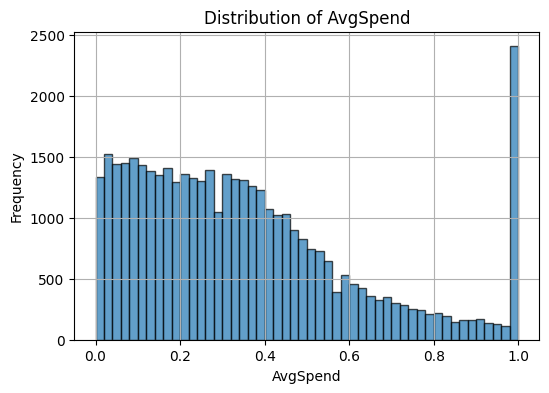

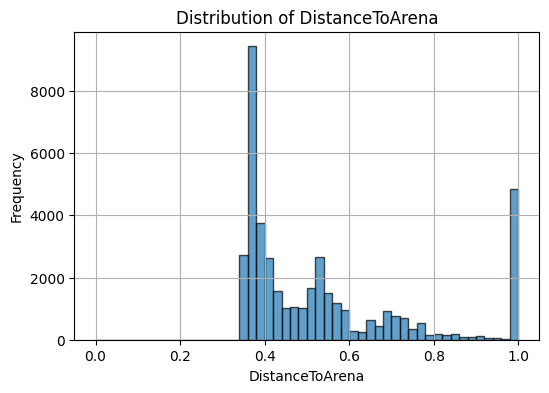

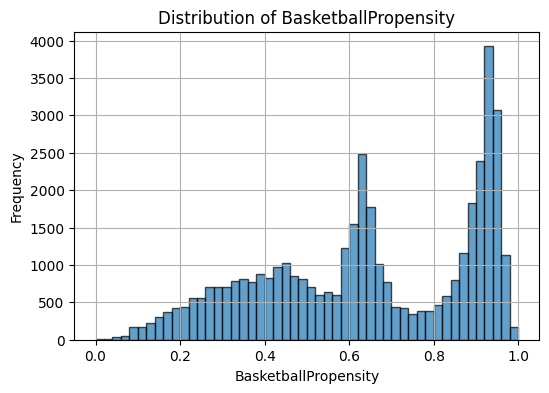

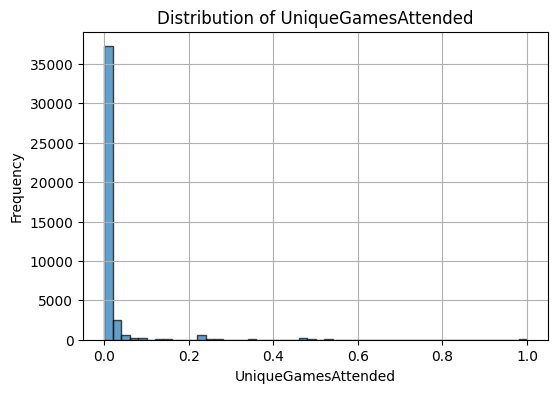

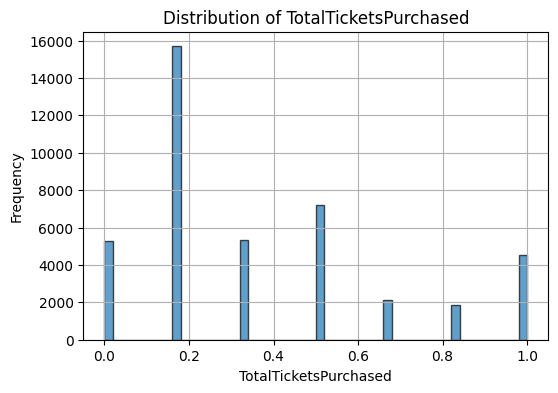

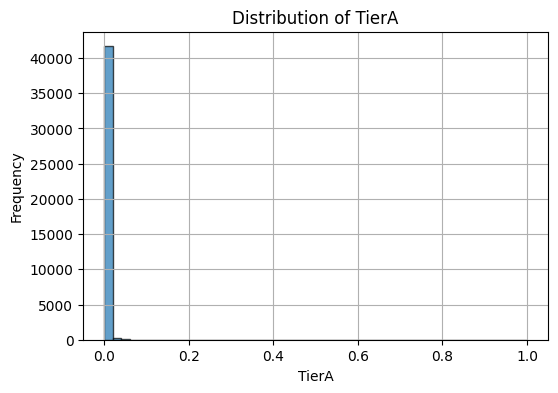

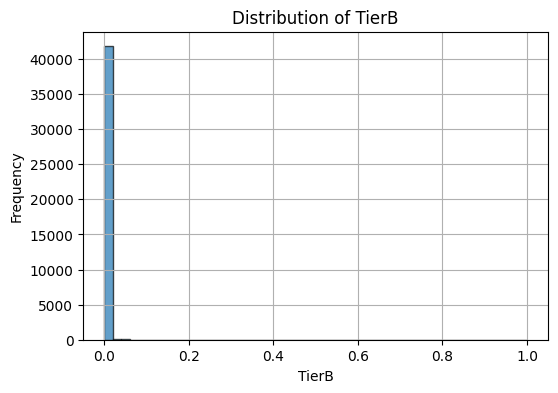

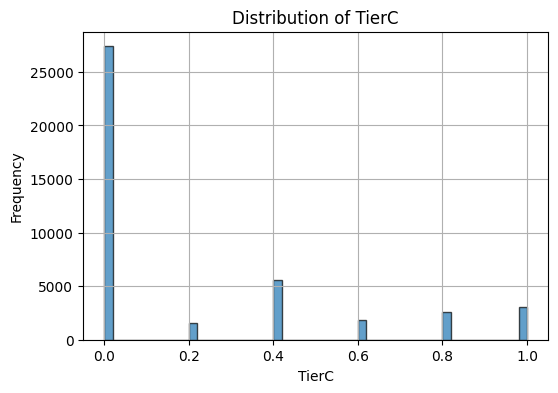

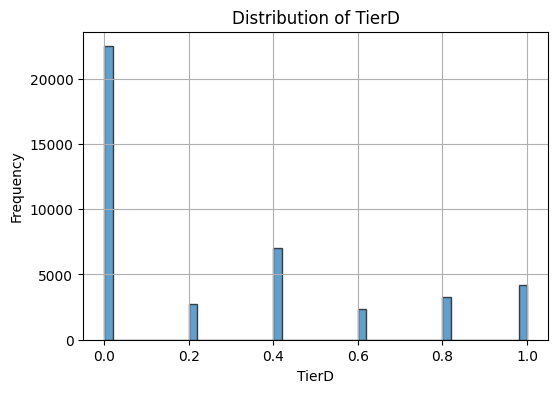

In [14]:
import matplotlib.pyplot as plt

# Define columns to skip from plotting
skip_columns = ["A_tier_games", "B_tier_games", "C_tier_games", "D_tier_games"]

# Plot the distributions of all numeric columns (regardless of normalization or capping), except for the skipped ones
for col in numeric_cols:
    if col in skip_columns:
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df_capped[col], bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppose numeric_cols has been defined and features is selected from df_capped
# For example:
# numeric_cols = ['AvgSpend_norm', 'DistanceToArena_norm', 'GamesAttended_norm', 'SocialMediaEngagement', ...]
# features = df_capped[numeric_cols]

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
exclude_cols = ["Season", "AccountNumber", "TierA", "TierB", "TierC", "TierD", "SingleGameTickets", "PartialPlanTickets", "GroupTickets", "GamesAttended", "FavoriteTier",'TierBFraction', 'TierCFraction', 'TierDFraction', 'TierAFraction']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

# Select only the numeric features (which have been normalized and had outliers capped)
features = df_capped[numeric_cols]


# Apply PCA: Option 1 - using a variance threshold (keep 90% of the variance)
pca = PCA(n_components=0.9, random_state=42)
features_reduced = pca.fit_transform(features)
print("Reduced features shape:", features_reduced.shape)
print("Explained variance ratio per component:", pca.explained_variance_ratio_)

# Initialize and fit K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=200)
df_capped["Cluster"] = kmeans.fit_predict(features)

# Evaluate the clustering using the silhouette score
score = silhouette_score(features, df_capped["Cluster"])
print("Silhouette Score:", score)

# Display the first few rows of the dataframe with the cluster labels
df_capped.head()


['AvgSpend', 'DistanceToArena', 'BasketballPropensity', 'SocialMediaEngagement', 'UniqueGamesAttended', 'TotalTicketsPurchased', 'TierABFraction', 'TierCDFraction', 'WeekendFraction', 'TierAWeekendFraction', 'TierBWeekendFraction', 'TierCWeekendFraction', 'TierDWeekendFraction', 'TierABWeekendFraction', 'TierCDWeekendFraction', 'GiveawayFraction']
Reduced features shape: (42016, 9)
Explained variance ratio per component: [0.29737801 0.25748579 0.08712024 0.06579235 0.06163971 0.05043112
 0.04112672 0.03598639 0.03496446]
Silhouette Score: 0.3826212487204635


,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,...,FavoriteTier,WeekendFraction,TierAWeekendFraction,TierBWeekendFraction,TierCWeekendFraction,TierDWeekendFraction,TierABWeekendFraction,TierCDWeekendFraction,GiveawayFraction,Cluster
0,2023,1,0,0,0,1.000000,0,F,0.381944,0.860599,...,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,2023,2,2,0,0,0.590331,1,A,0.462963,0.414747,...,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,2023,3,3,0,0,0.544529,1,B,0.368056,0.888249,...,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2023,4,0,0,3,0.137405,1,C,0.361111,0.394009,...,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2023,5,0,0,2,0.071247,1,A,0.363426,0.526498,...,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


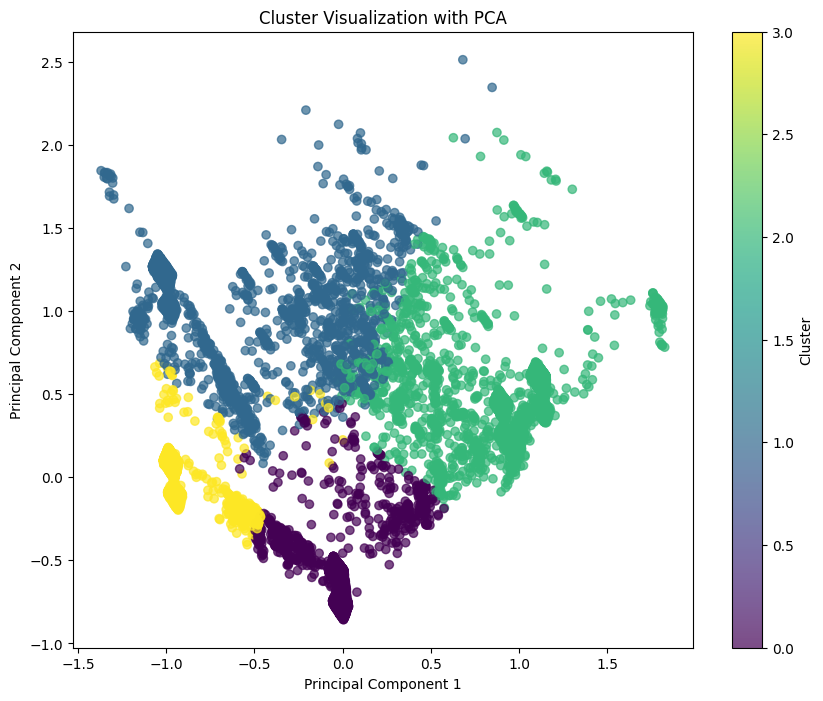

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the features used for clustering (the same as before)
features = df_capped[numeric_cols]

# Reduce the dimensions to 2 principal components
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features)

# Create a DataFrame for the reduced features
df_reduced = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
df_reduced['Cluster'] = df_capped["Cluster"]

# Plot the clusters using a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_reduced['PC1'], df_reduced['PC2'], 
c=df_reduced['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

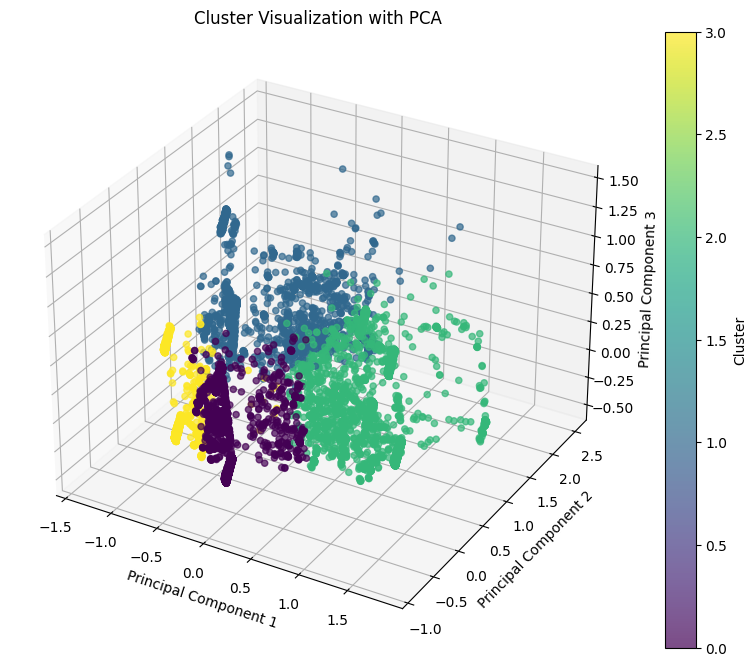

In [17]:
# Plot the clusters using a scatter plot
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit
# Reduce the dimensions to 3 principal components
pca = PCA(n_components=3, random_state=42)
reduced_features = pca.fit_transform(features)

# Create a DataFrame for the reduced features
df_reduced_2 = pd.DataFrame(reduced_features, columns=['PC1', 'PC2', 'PC3'])
df_reduced_2['Cluster'] = df_capped["Cluster"]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot using the reduced features and cluster labels
scatter = ax.scatter(df_reduced_2['PC1'], df_reduced_2['PC2'], df_reduced_2['PC3'],
                     c=df_reduced_2['Cluster'], cmap='viridis', alpha=0.7)

ax.set_title('Cluster Visualization with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a colorbar to show the mapping of colors to clusters
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()


In [18]:
# Calculate the additional metrics on the original dataframe
df["WeekdayGames"] = df["GamesAttended"] * (1 - df["WeekendFraction"])
df["WeekendGames"] = df["GamesAttended"] * df["WeekendFraction"]
df["AllTiersGames"] = df["SingleGameTickets"] + df["PartialPlanTickets"] + df["GroupTickets"]
df["PromoGames"] = df["GamesAttended"] * df["GiveawayFraction"]

# Group by FavoriteTier (A, B, C, D, etc.) and calculate the average metrics
tier_summary = df.groupby("FavoriteTier")[["WeekdayGames", "WeekendGames", "AllTiersGames", "PromoGames"]].mean()

print(tier_summary)


              WeekdayGames  WeekendGames  AllTiersGames  PromoGames
FavoriteTier                                                       
A                 0.227468      0.546097       3.873332    0.017405
B                 0.634201      0.164469       3.980798    0.138957
C                 0.472729      0.442642       4.296945    0.086866
D                 0.870934      0.262866       4.645815    0.395306


In [19]:
# Assign the cluster labels from the capped/normalized dataset back to the original dataframe.
# (This assumes the row indices still match.)
df["Cluster"] = df_capped["Cluster"]

# Compute the estimated count of games for each tier using the corresponding weekend fraction.
# Note: Adjust these formulas if you have a different method for determining tier game counts.
df["AB_tier_games"] = df["GamesAttended"] * df["TierABFraction"]
df["CD_tier_games"] = df["GamesAttended"] * df["TierCDFraction"]


# Group by the cluster label and compute the average count of games for each tier.
cluster_tier_summary = df.groupby("Cluster")[["AB_tier_games", "CD_tier_games"]].mean()

print(cluster_tier_summary)


         AB_tier_games  CD_tier_games
Cluster                              
0             0.018318       0.930097
1             0.790010       0.501110
2             0.079008       0.916084
3             0.671601       0.037342


In [20]:
# Calculate additional metrics on the original dataframe
df["WeekdayGames"] = df["GamesAttended"] * (1 - df["WeekendFraction"])
df["WeekendGames"] = df["GamesAttended"] * df["WeekendFraction"]
df["AllTiersGames"] = df["SingleGameTickets"] + df["PartialPlanTickets"] + df["GroupTickets"]
df["PromoGames"] = df["GamesAttended"] * df["GiveawayFraction"]

# Group by Cluster and calculate the average metrics
cluster_summary = df.groupby("Cluster")[["WeekdayGames", "WeekendGames", "AllTiersGames", "PromoGames"]].mean()

# Display the result
print(cluster_summary)


         WeekdayGames  WeekendGames  AllTiersGames  PromoGames
Cluster                                                       
0            0.936355      0.012059       3.577510    0.303083
1            0.463587      0.827533       7.680891    0.157675
2            0.179877      0.815215       4.557848    0.154914
3            0.704624      0.004319       3.209268    0.120988


- Cluster 0: PromoPlan
- Cluster 1: MarqueePlan
- Cluster 2: WeekendPlan
- Cluster 3: ValuePlan

In [21]:
# Create a pivot table showing the count of each FanSegment within each Cluster
cluster_fan_counts = df.groupby(["Cluster", "FanSegment"]).size().unstack(fill_value=0)

# Optionally, to view the percentage distribution per cluster, uncomment the following:
# cluster_fan_pct = cluster_fan_counts.div(cluster_fan_counts.sum(axis=1), axis=0)
# print("Percentage Distribution per Cluster:")
# print(cluster_fan_pct)

# Display the counts table
print("Fan Segment Counts by Cluster:")
print(cluster_fan_counts)


Fan Segment Counts by Cluster:
FanSegment     A     B     C     D    E    F    G  Limited Data
Cluster                                                        
0           3941  2596  1112  1443  506  619   96          8762
1           1034   816   296   389  178  271  139          2665
2           2147  1433   539   757  293  469  121          5244
3           1191   836   378   470  144  220   37          2874


In [22]:
# Create a pivot table showing the count of each FanSegment within each Cluster
cluster_fan_counts = df.groupby(["Cluster", "FanSegment"]).size().unstack(fill_value=0)

# Optionally, to view the percentage distribution per cluster, uncomment the following:
# cluster_fan_pct = cluster_fan_counts.div(cluster_fan_counts.sum(axis=1), axis=0)
# print("Percentage Distribution per Cluster:")
# print(cluster_fan_pct)

# Group by Cluster to compute the average AvgSpend and BasketballPropensity for each cluster
cluster_avg_metrics = df.groupby("Cluster")[["AvgSpend", "BasketballPropensity","DistanceToArena"]].mean()

print("\nAverage AvgSpend and BasketballPropensity by Cluster:")
print(cluster_avg_metrics)



Average AvgSpend and BasketballPropensity by Cluster:
           AvgSpend  BasketballPropensity  DistanceToArena
Cluster                                                   
0         64.712522            665.936623       142.718639
1        101.138595            714.063738       133.313074
2         71.323361            693.240659       158.796998
3         97.972463            691.707179       166.597961
